In [1]:
import numpy as np
import xarray as xr
import os

In [2]:
outdir='/work/jet/data/interim/'

# Odiv-255
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/'
# Odiv-233, 232, 231, 230
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/'
# Odiv-226, Odiv-210, Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/' # Odiv-183, Odiv-170

#subdir = 'CM4_historical_c192_OM4p125' # odiv-233/odiv-255
#subdir = 'CM4_ssp585_c192_OM4p25' # odiv-232
subdir = 'CM4_historical_c192_OM4p25' # Odiv-231
#subdir = 'CM4_piControl_c192_OM4p25_v8' # odiv-230
#subdir = 'CM4_piControl_c192_OM4p25_v7_npolefix' # Odiv-226
#subdir = 'CM4_piControl_c192_OM4p25_v7' # Odiv-210
#subdir = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt3' # Odiv-207
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt2' # Odiv-206
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200
#subdir = 'CM4_piControl_c192_OM4p125_v6' # Odiv-191
#subdir = 'CM4_piControl_c192_OM4p125_v5' # Odiv-184
#subdir = 'CM4_piControl_c192_OM4p125_v5_proto1' # Odiv-183
#subdir = 'CM4_piControl_c192_OM4p25' # Odiv-170

platform = 'gfdl.ncrc4-intel18-prod-openmp'
#platform = 'gfdl.ncrc5-intel22-prod-openmp' # odiv-255

In [3]:
pp = 'ocean_annual_z'
full_path = os.path.join(rootdir,subdir,platform,'pp',pp)+'/ts/annual/10yr/'

In [4]:
var = 'so'
tprd = '*'
print(full_path+pp+'.%s.%s.nc'%(tprd,var))

/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/ocean_annual_z.*.so.nc


In [5]:
vars_ds = xr.open_mfdataset(full_path+pp+'.%s.%s.nc'%(tprd,var),use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])

### Load mask and grid

In [6]:
print('Loading',pp+'.static.nc')
grid_ds = xr.open_dataset(os.path.join(rootdir,subdir,platform,'pp',pp)+'/'+pp+'.static.nc')

Loading ocean_annual_z.static.nc


In [7]:
#grid_ds = grid_ds.isel(xq=slice(None,-1),yq=slice(None,-1)) # p125
grid_ds = grid_ds.isel(xq=slice(1,None),yq=slice(1,None)) # p25

In [8]:
mhead = subdir.split('_')[3][3:]+'_d2' if pp.split('_')[-1]=='d2' else subdir.split('_')[3][3:]
print('Loading',mhead+'_1000m_Isobath_Contour_Transport_Masks.nc')
mask = xr.open_dataset(outdir[:-13]+'static/'+mhead+'_1000m_Isobath_Contour_Transport_Masks.nc')

Loading p25_1000m_Isobath_Contour_Transport_Masks.nc


In [9]:
import gsw

In [10]:
deptho_max = 1500
north = -60.0

Schmidtko et al. (2014): 
**ASBW** is defined using the deepest measurement in profiles within *30 m* of the bottom, or, in the absence of CTD altimeter data, within 150m of the ETOPO-1 bathymetry. **ASBW** data are mapped onto a 0.25$^{\circ}\times$0.125$^{\circ}$ grid for bathymetry shallower than *1500 m*. Data is from the period **1975–2012** for selected areas around Antarctica.

In [11]:
p = xr.apply_ufunc(gsw.p_from_z, -vars_ds['z_l'], grid_ds['geolat'], 0, 0, dask='parallelized')
sa = xr.apply_ufunc(gsw.SA_from_SP, vars_ds.so, p, grid_ds['geolon'], grid_ds['geolat'], dask='parallelized')         
da = sa.chunk({'time':1}).ffill('z_l').isel(z_l=-1).where(grid_ds.geolat<north).where(grid_ds.deptho<deptho_max).where(grid_ds.wet==1).rename(var)

In [12]:
if pp.split('_')[-1]=='d2':
    n_y = 245 if mhead=='p125' else 245
else:
    n_y = 490 if mhead=='p125' else 202 if mhead=='p25' else 91
    
da = da.isel(yh=slice(0,n_y)).where(mask.contour_masked_south==1)

In [13]:
ds = da.reset_coords(drop=True).to_dataset(name='bottom_sa')

In [14]:
ds['areacello'] = grid_ds.isel(yh=slice(0,n_y),yq=slice(0,n_y)).areacello
ds['deptho'] = grid_ds.isel(yh=slice(0,n_y),yq=slice(0,n_y)).deptho
ds['wet'] = grid_ds.isel(yh=slice(0,n_y),yq=slice(0,n_y)).wet
ds['geolon'] = grid_ds.isel(yh=slice(0,n_y),yq=slice(0,n_y)).geolon
ds['geolat'] = grid_ds.isel(yh=slice(0,n_y),yq=slice(0,n_y)).geolat
ds['shlf_mask'] = mask.reset_coords().contour_masked_south.fillna(0)

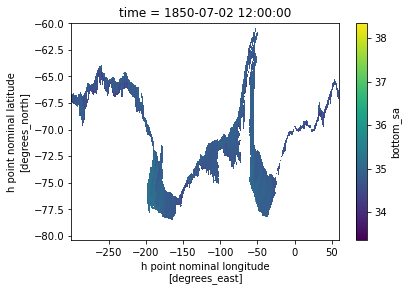

In [15]:
ds.bottom_sa[0].plot()

In [16]:
from dask.diagnostics import ProgressBar

In [17]:
var = 'asbw_sa'
tprd = '%sto%s'%(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'))
fname = subdir+'_so_%s_southof%sS_%s_%s.nc'%(tprd,str(abs(north)).replace('.',''),var,pp.split('_')[1])

print('Saving to file:', fname)
with ProgressBar():
    ds.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_historical_c192_OM4p25_so_1850to2009_southof600S_asbw_sa_annual.nc
[########################################] | 100% Completed |  3min  2.7s


In [18]:
#fname = 'CM4_historical_c192_OM4p125_so_1850to1969_southof600S_asbw_sa_annual.nc'
yr_st, yr_ed = '1940','1969'
ds = xr.open_dataset(outdir+fname)

In [19]:
sab = ds.bottom_sa.sel(time=slice(yr_st,yr_ed)).mean('time').load()

In [20]:
import cartopy
import matplotlib.pyplot as plt
import cmocean.cm as cmo
%matplotlib inline

import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import get_so_map_boundary
circle = get_so_map_boundary()

In [21]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [22]:
ds['sab'] = sab
ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat']})

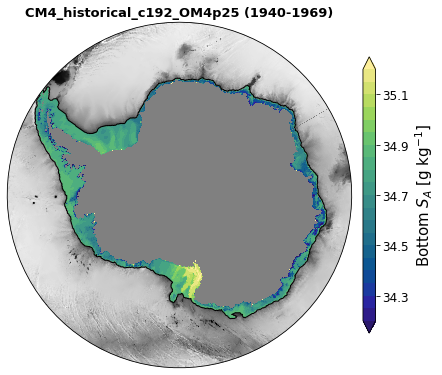

In [23]:
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

p = ds.sab.where(ds.wet==1).plot(ax=ax, x='geolon', y='geolat', vmin=34.2, vmax=35.2, cmap=cmo.haline, levels = 21, 
                                 add_labels=False, add_colorbar=False, transform=cartopy.crs.PlateCarree())
ds.shlf_mask.plot.contour(ax=ax, x='geolon', y='geolat', levels=[1000.0],linewidths=1, colors='k', transform=cartopy.crs.PlateCarree())
ds.deptho.where(ds.shlf_mask==0).plot(ax=ax, x='geolon', y='geolat',cmap='Greys_r',add_labels=False, 
                                      add_colorbar=False, transform=cartopy.crs.PlateCarree())
ax.set_title('%s (%s-%s)'%(subdir,yr_st,yr_ed), fontsize=13, fontweight='bold')

# Add separate colorbar
cb = plt.colorbar(p, ticks=np.arange(34.3,35.3,0.2), shrink=0.8, pad=0.02, orientation='vertical')
cb.set_label(r'Bottom $S_{A}$ [g kg$^{-1}$]', fontsize=15)
cb.ax.tick_params(labelsize=12)

plt.show()

In [12]:
ds_obs = xr.open_dataset('/work/jet/Schmidtko_Antarctic_shelf_data.nc',decode_times=False)

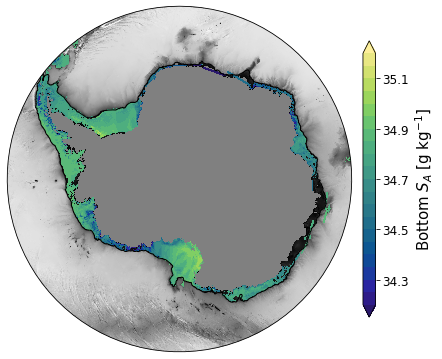

In [27]:
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ds.deptho.plot(ax=ax, x='geolon', y='geolat',cmap='Greys_r',add_labels=False, 
                                      add_colorbar=False, transform=cartopy.crs.PlateCarree(),zorder=0)

p = ds_obs.sa.plot(ax=ax, x='lon', y='lat', vmin=34.2, vmax=35.2, cmap=cmo.haline, levels = 21, 
                   add_labels=False, add_colorbar=False, transform=cartopy.crs.PlateCarree(),zorder=1)
ds.shlf_mask.plot.contour(ax=ax, x='geolon', y='geolat', levels=[1000.0],linewidths=1, colors='k', 
                          transform=cartopy.crs.PlateCarree(),zorder=2)

# Add separate colorbar
cb = plt.colorbar(p, ticks=np.arange(34.3,35.3,0.2), shrink=0.8, pad=0.02, orientation='vertical')
cb.set_label(r'Bottom $S_{A}$ [g kg$^{-1}$]', fontsize=15)
cb.ax.tick_params(labelsize=12)

plt.show()